# Travel Planning Agent with LangGraph on AWS Trainium
---

This notebook demonstrates how to build a conversational travel planning agent using LangGraph and LangChain on AWS Trainium infrastructure. The agent leverages the Llama-3.2-3B-Instruct model running on AWS Neuron for efficient inferencing to create interactive travel itineraries based on user interests. Through this notebook, you'll learn how to set up a stateful agent workflow that maintains conversation context and progressively refines travel plans across multiple interactions.

The notebook showcases:
- Setting up VLLMOpenAI with AWS Neuron infrastructure
- Building a state management system with LangGraph
- Creating a multi-turn conversational experience
- Implementing a travel itinerary planner with memory persistence
- Leveraging AWS Trainium's neural network acceleration for LLM inference

This practical example demonstrates how to combine AWS's specialized ML hardware with modern agent frameworks to create responsive, contextually-aware applications.


---
## Getting Started
---

In [ ]:
%pip install --quiet requirements.txt

In [1]:
from IPython.display import Image
from typing import TypedDict, Annotated, List
from langchain_community.llms import VLLMOpenAI
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.graph import MermaidDrawMethod
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

## Agentic Workflow with LangGraph

First, we are initializing the ```StateGraph```. This object will encapsulate the graph being traversed during excecution.

Then we define the **nodes** in our graph. In LangGraph, nodes are typically python functions. There are two main nodes we will use for our graph:
- The agent node: responsible for deciding what (if any) actions to take.
- The tool node: This node will orchestrate calling the respective tool and returning the output. This means if the agent decides to take an action, this node will then execute that action.

**Edges** define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- Normal Edges: Go directly from one node to the next.
- Conditional Edges: Call a function to determine which node(s) to go to next.
- Entry Point: Which node to call first when user input arrives.
- Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

In our case we need to define a conditional edge that routes to the ```ToolNode``` when a tool get called in the agent node, i.e. when the LLM determines the requirement of tool use. With ```tools_condition```, LangGraph provides a preimplemented function handling this. Further, an edge from the ```START```node to the ```assistant```and from the ```ToolNode``` back to the ```assistant``` are required.

We are adding the nodes, edges as well as a persistant memory to the ```StateGraph``` before we compile it. 

### Define Agent State

We'll define the state that our agent will maintain throughout its operation. First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.  The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

### Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.
5. **Memory Integration**: Utilizing long term and short term memory for conversations

### Define Agent Nodes

we will create a simple graph with:

- user travel plans
- invoke with SageMaker JumpStart and Mistral Small 3
- generate the travel plan for the day 
- ability to add or modify the plan

In [5]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    itinerary: str
    city: str
    user_message: str

### Set Up Language Model and Prompts

In [2]:
llm = VLLMOpenAI(
    openai_api_key="EMPTY",
    openai_api_base="http://localhost:8080/v1",
    model_name="models/llama-3.2-3b-instruct"
)

In [3]:
itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. Use the below chat conversation and the latest input from Human to get the user interests. Provide a brief, bulleted itinerary."),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])

### Define the nodes and Edges

In [6]:
def input_interests(state: PlannerState) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    #print(f"We are going to :: {user_message}:: for trip to {state['city']} based on your interests mentioned in the prompt....")

    if not state.get('messages', None) : state['messages'] = []
    return {
        **state,
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=state['messages']))
    print("\nFinal Itinerary:")
    print(response)
    return {
        **state,
        "messages": state['messages'] + [HumanMessage(content=state['user_message']),AIMessage(content=response)],
        "itinerary": response
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it. We build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above. Then, we add our nodes and edges. We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph. The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 


In [7]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Display the graph structure

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

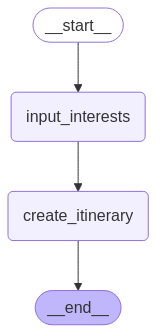

In [8]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs. In the following example, we run `stream()` to invoke the graph with inputs

In [9]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

### Travel Planner Example

- To run this the system prompts and asks for user input for activities 
- We have initialized the graph state with city Seattle which usually will be dynamic and we will see in subsequrnt labs
- You can enter like boating, swiming

In [10]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for boating, swim. Need a complete plan


Final Itinerary:
 for Seattle.

Let me help you plan a fun-filled day trip in Seattle! Here's a suggested itinerary based on your interests in boating and swimming:


*   **9:00 AM - 10:00 AM: Morning Kayaking at Lake Union and Lake Washington**
    You can start your day with a leisurely kayak trip around Lake Union and Lake Washington. Rent kayaks at Gas Works Park or Lake Union and enjoy the scenic views of the city skyline.
*   **10:00 AM - 12:00 PM: Visit the Washington Park Arboretum**
    After kayaking, head to the Washington Park Arboretum, a 230-acre park featuring beautiful gardens, walking trails, and a tranquil atmosphere. It's a great place to relax and enjoy nature.
*   **12:00 PM - 1:30 PM: Lunch at Pike Place Market**
    Take a break for lunch at Pike Place Market, one of the oldest continuously operating farmers' markets in the country. You can find a variety of food options, i

#### Leverage the memory saver to manipulate the Graph State
- Since the `Conversation Messages` are part of the graph state we can leverage that
- However the graph state is tied to `session_id` which will be passed in as a `thread_id` which ties to a session
- If we add a request with different thread id it will create a new session which will not have the previous `Interests`
- However this this has the other check points variables as well and so this pattern is good for `A-Sync` workflow

In [11]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:


AI:  for Seattle.

I'd be happy to add white water rafting to your itinerary. Here's an updated plan:


*   **9:00 AM - 10:00 AM: Morning Kayaking at Lake Union and Lake Washington**
    You can start your day with a leisurely kayak trip around Lake Union and Lake Washington. Rent kayaks at Gas Works Park or Lake Union and enjoy the scenic views of the city skyline.
*   **10:00 AM - 11:30 AM: White Water Rafting at the Snoqualmie River**
    Next, head to the Snoqualmie River for a thrilling white water rafting experience. You can take a guided tour or rent equipment and navigate the rapids on your own.
*   **11:30 AM - 12:00 PM: Snack Break**
    Take a short break to refuel and grab a snack after your rafting adventure.
*   **12:00 PM - 1:30 PM: Lunch at Pike Place Market**
    Take a break for lunch at Pike Place Market, one of the oldest continuously operating farmers' markets in the countr